# Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO

from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance,PranglePopulationSize,PrangleEpsilon

# Get experimental measurements

In [2]:
myokit_python = ("/scratch/cph211/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('ikr')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [3]:
limits = dict(g_Kr=(0, 1),
              p1=(0, 1),
              p2=(0, 1),
              p3=(0, 1),
              p4=(0, 1),
              p5=(-1, 1),
              p6=(-1, 1),
              q1=(0, 1),
              q2=(-1, 1),
              q3=(0, 1.0),
              q4=(-0.5, 0.5),
              q5=(0, 0.01),
              q6=(-0.1, 0),
              k_f=(0, 1.0),
              k_b=(0, 1.0))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Define ABC parameters and initialise database

In [4]:
def model_measure(df):
    keys = range(len(df))
    return dict(zip(keys, df.y))
myokit_model = MyokitSimulation('ikr', measure_fn=model_measure)
myokit_model.sample({})

{0: -0.060985000000000004,
 1: 0.046327999999999994,
 2: 0.25306,
 3: 0.47727299999999995,
 4: 0.6177,
 5: 0.630735,
 6: 0.543991,
 7: 0.415447,
 8: 0.29233000000000003,
 9: 0.195741,
 10: 0.12730999999999998,
 11: 0.08125800000000001,
 12: 0.051169,
 13: 0.408767,
 14: 0.49552299999999994,
 15: 0.609901,
 16: 0.689519,
 17: 0.785504,
 18: 0.8804290000000001,
 19: 0.944427,
 20: 0.97993,
 21: 0.9949530000000001,
 22: 0.999114,
 23: 0.9999299999999999,
 24: 0.9998819999999999,
 25: 1.0,
 26: 0.9999889999999999,
 27: 1.0,
 28: 0.9637959999999999,
 29: 0.879769,
 30: 0.762968,
 31: 0.632425,
 32: 0.504892,
 33: 0.391092,
 34: 0.295757,
 35: 0.219388,
 36: 0.160142,
 37: 0.115196,
 38: 0.081683,
 39: 0.056973,
 40: 0.038925}

In [5]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikr.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikr.db


In [8]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(
                 exp_map=exp,
                 err_bars=errs,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(
                 500, alpha=0.5,
                 adapt=True,
                 mean_cv=0.5,
                 min_population_size=100,
                 max_population_size=1000),
             eps=PrangleEpsilon(initial_epsilon=100, alpha=0.5),
             sampler=MulticoreEvalParallelSampler(n_procs=24))

In [9]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is 100
INFO:History:Start <ABCSMC(id=1, start_time=2018-08-15 14:39:13.102399, end_time=None)>


In [10]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=5)

INFO:ABC:t:0 M eps:[100]
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph211/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = df_weighted.w.as_matrix()
INFO:ABC:t:0 N eps:5.4769213098974445
INFO:ABC:N population size: 500
INFO:ABC:t:1 M eps:[100.           5.47692131]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_ma

In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=20)

INFO:ABC:t:5 M eps:[100.           5.47692131   4.7229038    4.30900624   4.1493452
   4.04528645]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 1000 -> 1000
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/scratch/cph211/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method

INFO:ABC:N population size: 1000
INFO:ABC:t:12 M eps:[100.           5.47692131   4.7229038    4.30900624   4.1493452
   4.04528645   3.89756137   3.80116464   3.67397415   3.60882634
   3.59210963   3.5201982    3.40063707]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 1000 -> 1000
/scratch/cph211/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.

# Results analysis

In [69]:
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ikr.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-08-15 10:57:10.843899, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-08-15 11:46:02.357011, end_time=2018-08-15 12:32:09.137152)>,
 <ABCSMC(id=3, start_time=2018-08-15 13:15:43.956102, end_time=2018-08-15 13:22:33.896565)>,
 <ABCSMC(id=4, start_time=2018-08-15 13:50:48.041462, end_time=2018-08-15 13:57:14.219727)>,
 <ABCSMC(id=5, start_time=2018-08-15 14:12:27.310840, end_time=2018-08-15 14:17:58.742404)>]

In [70]:
history.id = 5

In [71]:
post_df, post_w = history.get_distribution(m=0)

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [72]:
post_df.keys()

Index(['g_Kr', 'k_b', 'k_f', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'q1', 'q2',
       'q3', 'q4', 'q5', 'q6'],
      dtype='object', name='name')

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


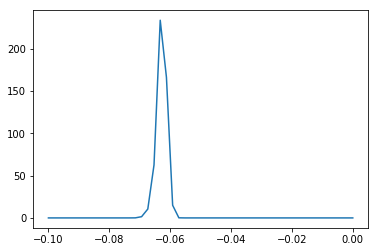

In [88]:
from pyabc.visualization import kde_1d
key = 'q6'
x, pdf = kde_1d(post_df, post_w, key, xmin=limits[key][0], xmax=limits[key][1])
plt.plot(x, pdf)

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


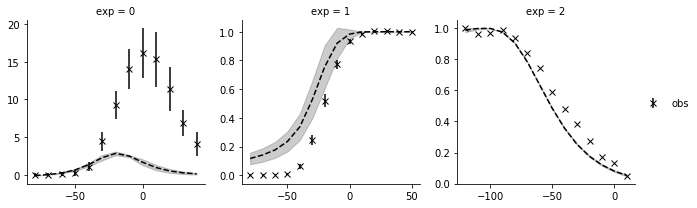

In [14]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ikr', n_samples=5, obs=measurements, n_x=None)

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


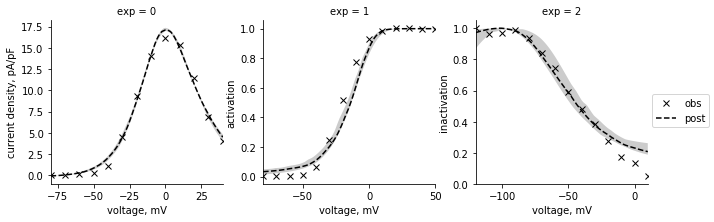

In [12]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ikr', n_samples=10, obs=measurements, original=False)
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
plt.savefig("ikr_results.pdf", format='pdf', dpi=1000)

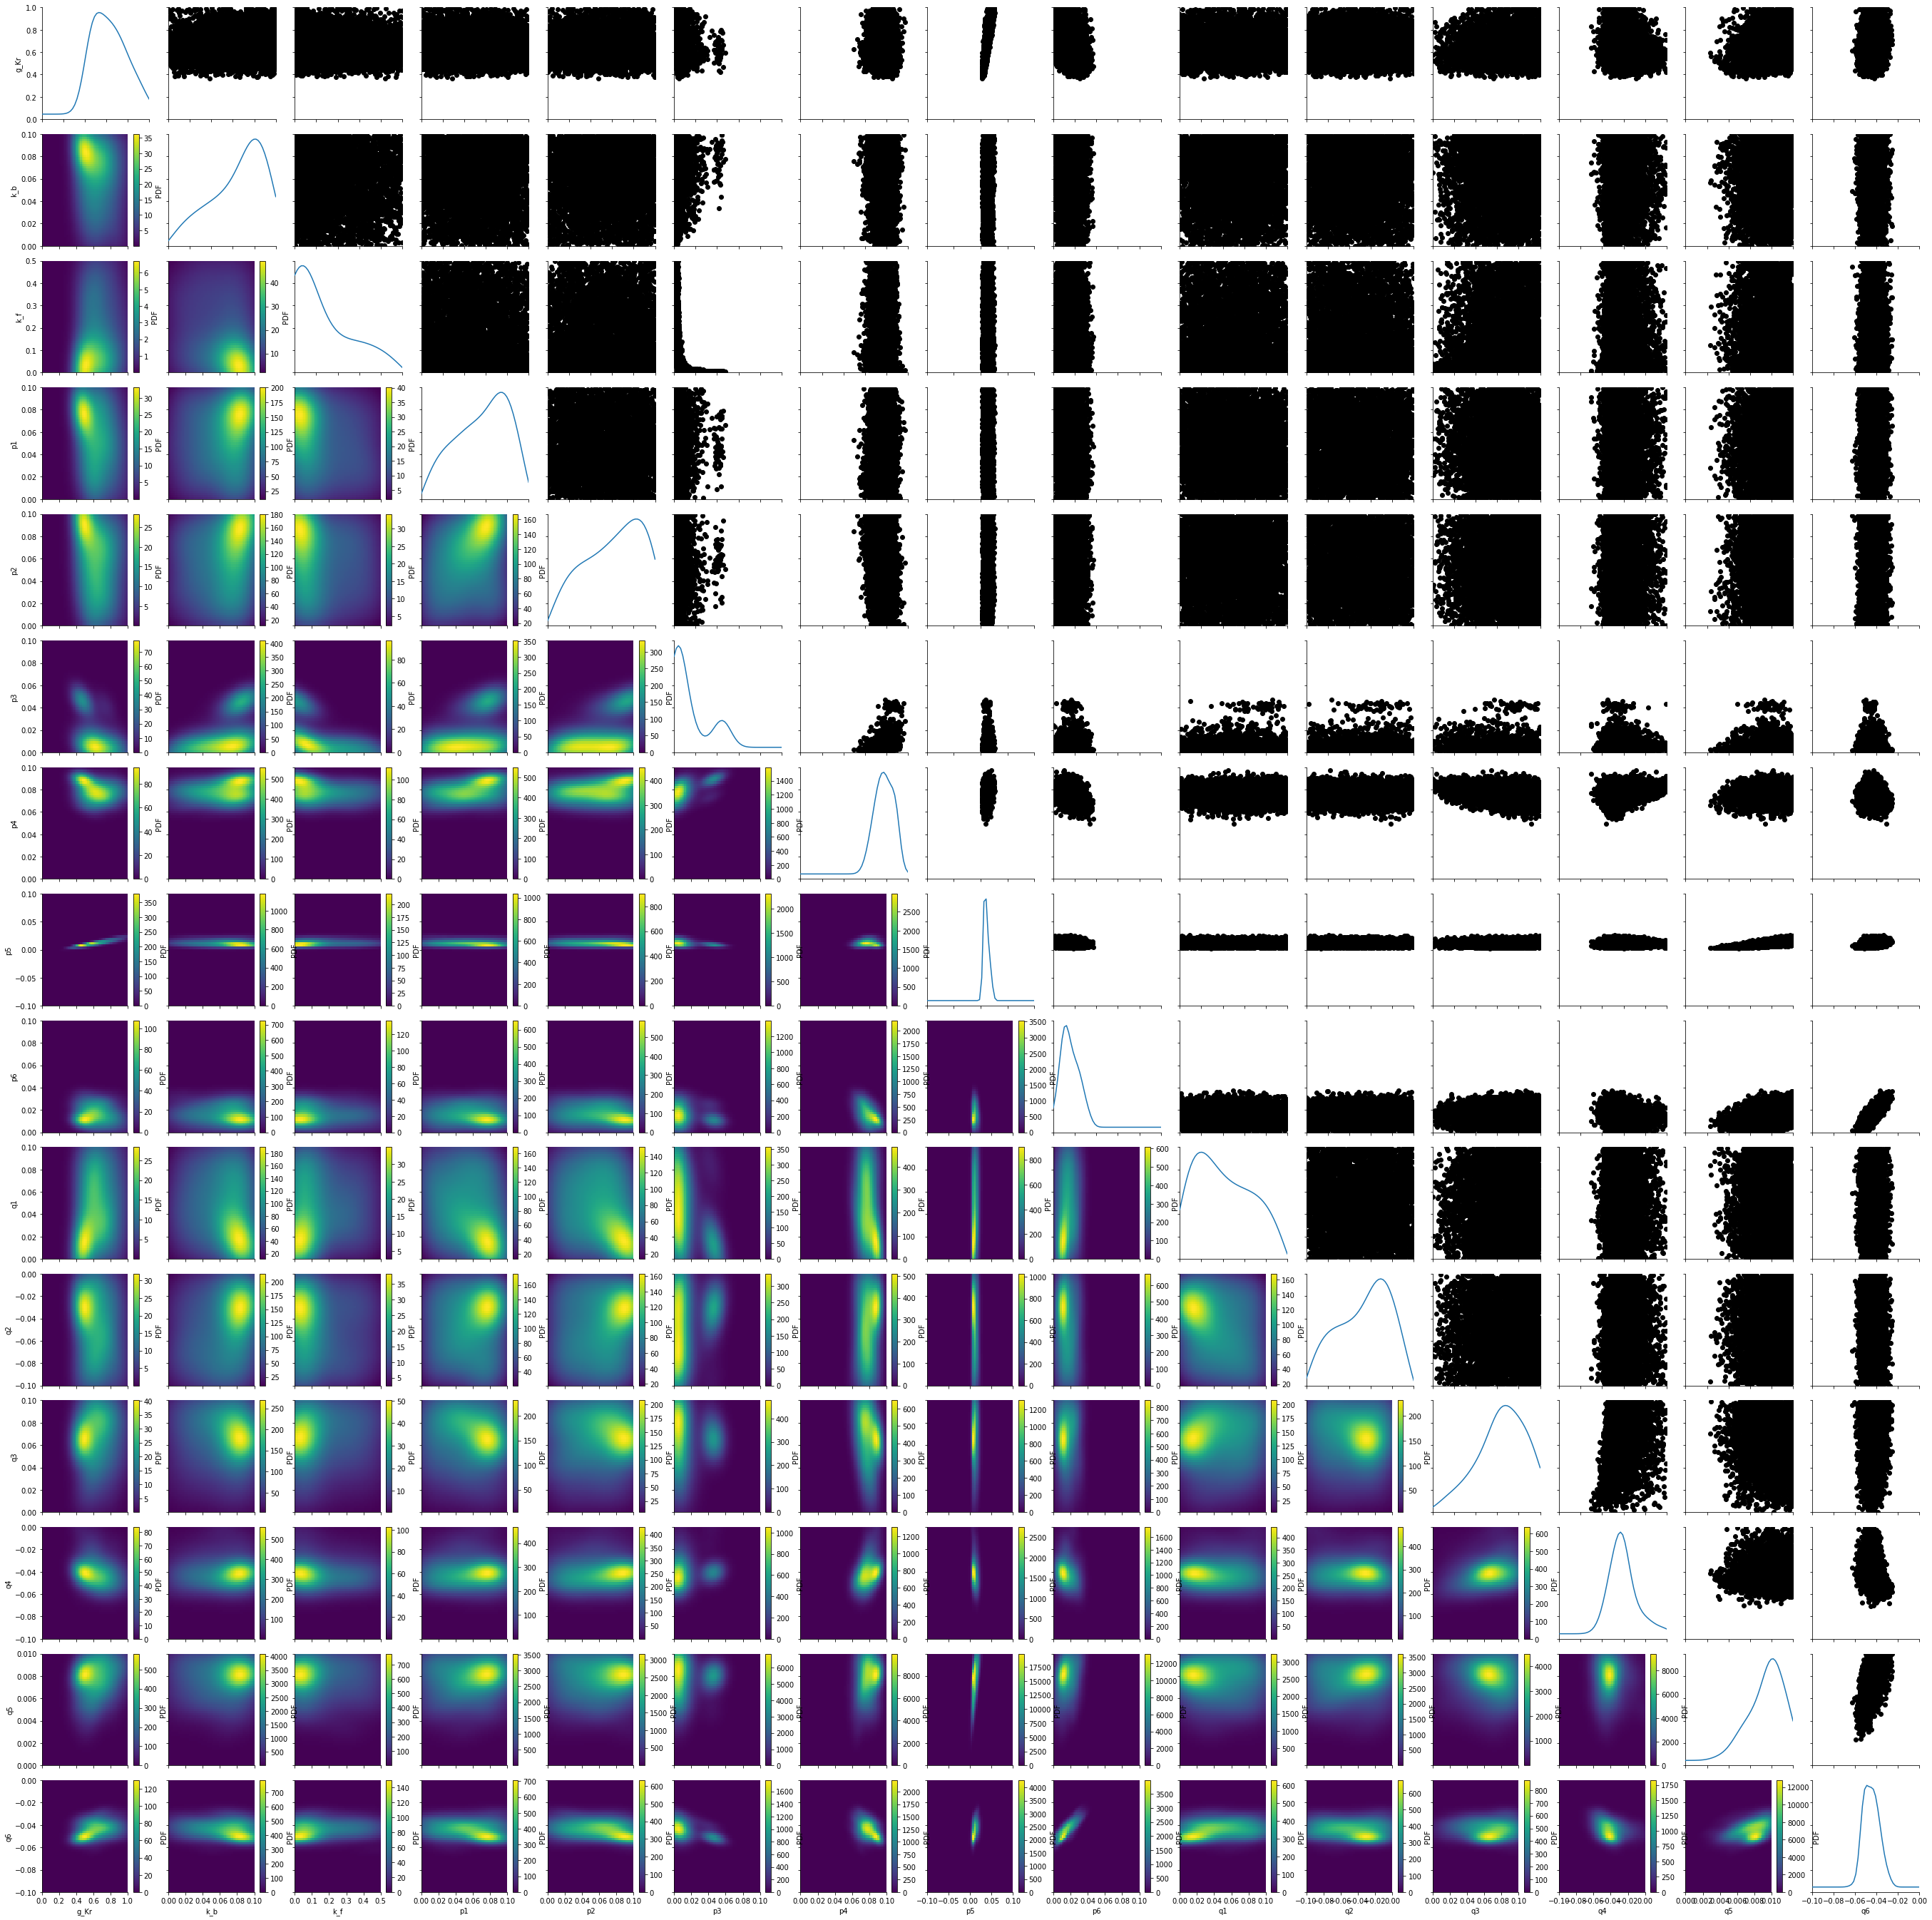

In [20]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

run
0     AxesSubplot(0.125,0.125;0.775x0.755)
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

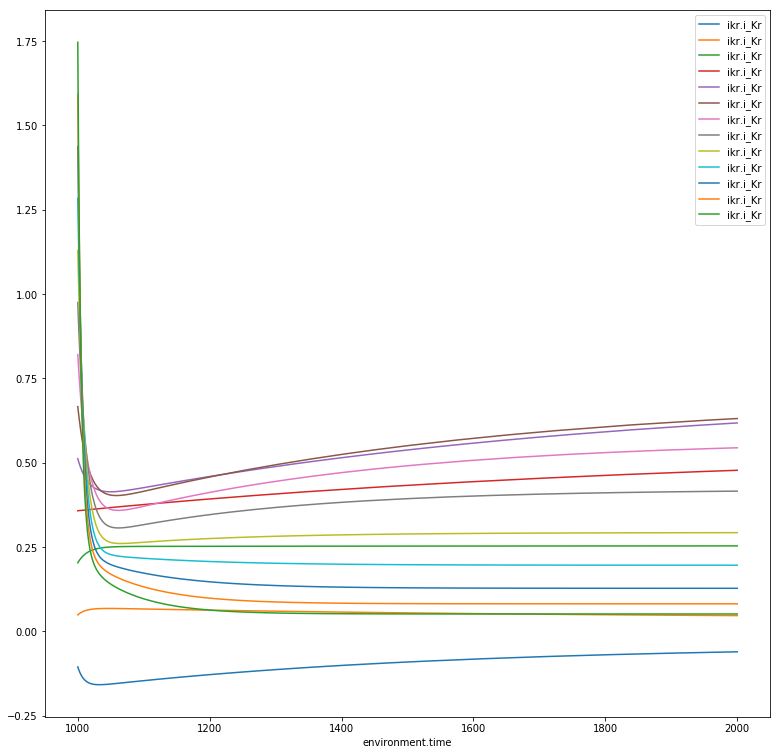

In [25]:
from pyabc_custom import simulate
out = simulate('ikr', experiment=0, logvars=['environment.time', 'ikr.i_Kr'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby('run').plot(x='environment.time', y='ikr.i_Kr',ax=ax)